# Load Packages

In [1]:
#Using smth means: pre-compile and load smth as a package.
using Pkg;
#Set the Gurobi path
ENV["GUROBI_HOME"] = "C:\\Program Files\\gurobi912\\win64\\"
#For first timers (comment after): compile Gurobi with the given path
# Pkg.build("Gurobi")
#Add the packages that may not be installed.
Pkg.add(["Latexify", "Polyhedra", "Makie", "CDDLib", "JuMP", "Gurobi", "JLD", "HDF5", "Plots"])
#Load the packages
using JuMP, Latexify, Gurobi, LinearAlgebra, Polyhedra, CDDLib, SparseArrays, JLD, HDF5, Plots

display("Initialization done! All set :-)")

    Updating registry at `C:\Users\Alexr\.julia\registries\General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
  No Changes to `C:\Users\Alexr\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\Alexr\.julia\environments\v1.6\Manifest.toml`


"Initialization done! All set :-)"

# Load Data

In [2]:
function get_data(instance)
    if (instance==1)
        data = load("../data/X1-3.jld")["X"]
    elseif(instance==2)
        data = load("../data/X2-2.jld")["X"]
    else
        data = load("../data/X3-2.jld")["X"]
    end
    return data
end

get_data (generic function with 1 method)

# Create Gurobi Problem

In [3]:
function get_new_model() 
    return Model(Gurobi.Optimizer)
end

get_new_model (generic function with 1 method)

# Calculate Distance Matrix

In [4]:
function get_dist_matrix(data)
    k = Array{Float64}(undef, size(data,1), size(data,1))
    for i = 1:size(data,1)
        for j = 1:size(data,1)
            k[i,j] = sqrt((data[i,1]-data[j,1])^2 + (data[i,2]-data[j,2])^2)
        end
    end
    return k
end

get_dist_matrix (generic function with 1 method)

# Create Constraints

In [5]:
function get_constraints(data, instance)
    if (instance == 1)
        n_min = 2
        n_max = 8
        d_max = 10
    else
        n_min = 4
        n_max = 6
        d_max = 9
    end    
    max_clients = Int(size(data,1))
    max_depots = Int(ceil(max_clients/n_min))
    return (max_clients, n_max, n_min, d_max, max_depots)
end

get_constraints (generic function with 1 method)

# Define Symbolic Constraint Variables
$$C = \text{number of clients}$$
$$D = \text{maximum number of depots} = \frac{C}{n_{min}}$$
$$x_{cd} = \begin{cases}      1, & \text{if depot }d \text{ services client }c\ \\
      0, & \text{otherwise}
    \end{cases} \\
y_{d} = \begin{cases}      1, & \text{if depot } d \text{ exists} \\
      0, & \text{otherwise}
    \end{cases} $$
$$k_{c_1c_2} = \text{Euclidean distance from client } c_1 \text{ to client }c_2 $$

# Create y

In [6]:
function add_y(model, max_depots)
    return @variable(model, y[1:max_depots], base_name = "y", binary=true)
end

add_y (generic function with 1 method)

# Create x

In [7]:
function add_x(model, max_depots, max_clients)
    return @variable(model, x[1:max_clients,1:max_depots], base_name = "x", binary=true)
end

add_x (generic function with 1 method)

# Add objective
Minimise the number of depots:
$$ min\left(\sum_{d=1}^{D}y_d\right) $$

In [8]:
function add_objective(model, y)
    return @objective(model, Min, sum(y))
end

add_objective (generic function with 1 method)

# Add Constraint 1
If a depot exists, ensure that it serves no more than $n_{max}$ clients:
$$\sum_{c=1}^Cx_{cd}\leq n_{max}*y_d \text{ }\forall d\in 1...D$$

In [9]:
function add_constraint_1(model, max_clients, n_max, n_min, d_max, max_depots, k, x, y)
    for d in 1:max_depots
        constraint_expr = @expression(model, 0)
        for c in 1:max_clients
            constraint_expr += x[c,d]
        end
        @constraint(model, constraint_expr<=n_max*y[d])
    end
end

add_constraint_1 (generic function with 1 method)

# Add constraint 2
If a depot exists, ensure that it serves no less than $n_{min}$ clients:
$$\sum_{c=1}^Cx_{cd}\geq n_{min}*y_d\text{ }\forall d \in 1...D$$

In [10]:
function add_constraint_2(model, max_clients, n_max, n_min, d_max, max_depots, k, x, y)
    for d in 1:max_depots
        constraint_expr = @expression(model, 0)
        for c in 1:max_clients
            constraint_expr += x[c,d]
        end
        @constraint(model, constraint_expr>=n_min*y[d])
    end
end

add_constraint_2 (generic function with 1 method)

# Constraint 3
Ensure that every client is served by exactly 1 depot:
$$\sum_{d=1}^Dx_{cd}= 1\text{ }\forall c \in 1...C$$

In [11]:
function add_constraint_3(model, max_clients, n_max, n_min, d_max, max_depots, k, x, y)
    for c in 1:max_clients
        constraint_expr = @expression(model, 0)
        for d in 1:max_depots
            constraint_expr += x[c,d]
        end
        @constraint(model, constraint_expr==1)
    end
end

add_constraint_3 (generic function with 1 method)

# Constraint 4
Ensure that the euclidean distance between any pair of clients served by the same depot is not larger than $d_{max}$:
$$k_{{c_1}{c_2}}*x_{c_1d}*x_{c_2d}\leq d_{max}\text{ }\forall c_1\in 1...C,\text{ }\forall c_2 \in 1...C,\text{ } \forall d \in 1...D$$
In practice, this can made more efficient due to the fact that the euclidean distance from point $c_i \text{ to } c_j$ is the same as from $c_j \text{ to } c_i$ and the distance from $c_i \text{ to } c_i = 0$. This optimisation is made in the code below.

In [12]:
function add_constraint_4(model, max_clients, n_max, n_min, d_max, max_depots, k, x, y)
    for d in 1:max_depots
        for c1 in 1:max_clients
            for c2 in 1:c1-1
                @constraint(model, k[c1,c2]*x[c1,d]*x[c2,d]<=d_max)
            end
        end
    end
end

add_constraint_4 (generic function with 1 method)

# Plotting Function

In [13]:
function plot_results(data, x, y)
    scatter()
    for y_pos in 1:size(y, 1)
        if(value.(y)[y_pos]==1)
            temp_x = []
            temp_y = []
            for x_pos in 1:size(x, 1)
                if(value.(x)[x_pos,y_pos]==1.0)
                    push!(temp_x, data[x_pos,1])
                    push!(temp_y, data[x_pos,2])
                end
            end
            plot!(temp_x,temp_y, seriestype = :scatter)
        end
    end
    display(plot!())
end

plot_results (generic function with 1 method)

# Solve
## Instance 1

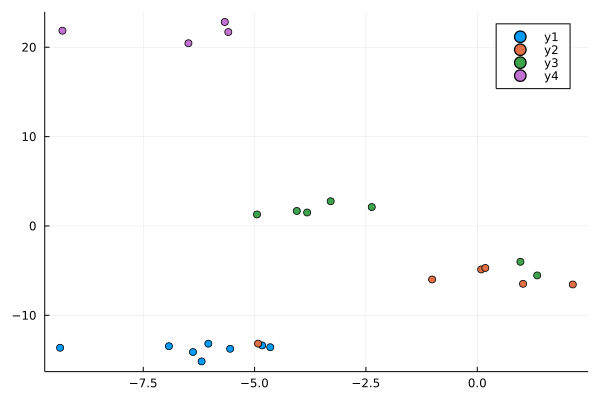

Academic license - for non-commercial use only - expires 2022-01-25
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 51 rows, 338 columns and 1001 nonzeros
Model fingerprint: 0xe8a5375f
Model has 3900 quadratic constraints
Variable types: 0 continuous, 338 integer (338 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+00]
  QMatrix range    [2e-01, 4e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
  QRHS range       [1e+01, 1e+01]
Presolve time: 0.06s
Presolved: 4627 rows, 2626 columns, 10153 nonzeros
Variable types: 0 continuous, 2626 integer (2626 binary)
Found heuristic solution: objective 12.0000000
Found heuristic solution: objective 11.0000000

Root relaxation: objective 4.000000e+00, 1094 iterations, 0.05 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj

In [14]:
data_1 = get_data(1)
dist_matrix_1 = get_dist_matrix(data_1)
max_clients_1, n_max_1, n_min_1, d_max_1, max_depots_1 = get_constraints(data_1, 1)
model_1 = get_new_model()
x_1 = add_x(model_1, max_depots_1, max_clients_1)
y_1 = add_y(model_1, max_depots_1)
add_objective(model_1, y_1)
add_constraint_1(model_1, max_clients_1, n_max_1, n_min_1, d_max_1, max_depots_1, dist_matrix_1, x_1, y_1)
add_constraint_2(model_1, max_clients_1, n_max_1, n_min_1, d_max_1, max_depots_1, dist_matrix_1, x_1, y_1)
add_constraint_3(model_1, max_clients_1, n_max_1, n_min_1, d_max_1, max_depots_1, dist_matrix_1, x_1, y_1)
add_constraint_4(model_1, max_clients_1, n_max_1, n_min_1, d_max_1, max_depots_1, dist_matrix_1, x_1, y_1)
optimize!(model_1)
if(has_values(model_1))
    plot_results(data_1, x_1, y_1)
end

## Instance 2

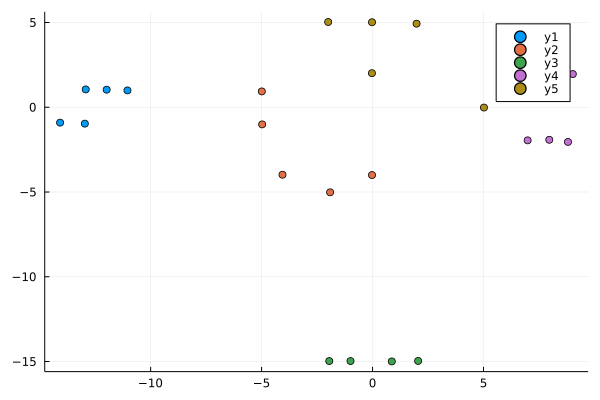

Academic license - for non-commercial use only - expires 2022-01-25
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 39 rows, 182 columns and 539 nonzeros
Model fingerprint: 0x5c9a8ada
Model has 2100 quadratic constraints
Variable types: 0 continuous, 182 integer (182 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  QMatrix range    [9e-01, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
  QRHS range       [9e+00, 9e+00]
Presolve time: 0.04s
Presolved: 2979 rows, 1652 columns, 6419 nonzeros
Variable types: 0 continuous, 1652 integer (1652 binary)
Found heuristic solution: objective 6.0000000

Root relaxation: objective 5.000000e+00, 329 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Nod

In [15]:
data_2 = get_data(2)
dist_matrix_2 = get_dist_matrix(data_2)
max_clients_2, n_max_2, n_min_2, d_max_2, max_depots_2 = get_constraints(data_2, 2)
model_2 = get_new_model()
x_2 = add_x(model_2, max_depots_2, max_clients_2)
y_2 = add_y(model_2, max_depots_2)
add_objective(model_2, y_2)
add_constraint_1(model_2, max_clients_2, n_max_2, n_min_2, d_max_2, max_depots_2, dist_matrix_2, x_2, y_2)
add_constraint_2(model_2, max_clients_2, n_max_2, n_min_2, d_max_2, max_depots_2, dist_matrix_2, x_2, y_2)
add_constraint_3(model_2, max_clients_2, n_max_2, n_min_2, d_max_2, max_depots_2, dist_matrix_2, x_2, y_2)
add_constraint_4(model_2, max_clients_2, n_max_2, n_min_2, d_max_2, max_depots_2, dist_matrix_2, x_2, y_2)
optimize!(model_2)
if(has_values(model_2))
    plot_results(data_2, x_2, y_2)
end

## Instance 3

In [16]:
data_3 = get_data(3)
dist_matrix_3 = get_dist_matrix(data_3)
max_clients_3, n_max_3, n_min_3, d_max_3, max_depots_3 = get_constraints(data_3, 3)
model_3 = get_new_model()
x_3 = add_x(model_3, max_depots_3, max_clients_3)
y_3 = add_y(model_3, max_depots_3)
add_objective(model_3, y_3)
add_constraint_1(model_3, max_clients_3, n_max_3, n_min_3, d_max_3, max_depots_3, dist_matrix_3, x_3, y_3)
add_constraint_2(model_3, max_clients_3, n_max_3, n_min_3, d_max_3, max_depots_3, dist_matrix_3, x_3, y_3)
add_constraint_3(model_3, max_clients_3, n_max_3, n_min_3, d_max_3, max_depots_3, dist_matrix_3, x_3, y_3)
add_constraint_4(model_3, max_clients_3, n_max_3, n_min_3, d_max_3, max_depots_3, dist_matrix_3, x_3, y_3)
optimize!(model_3)
if(has_values(model_3))
    plot_results(data_3, x_3, y_3)
end

Academic license - for non-commercial use only - expires 2022-01-25
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 39 rows, 182 columns and 539 nonzeros
Model fingerprint: 0xecfbc8bd
Model has 2100 quadratic constraints
Variable types: 0 continuous, 182 integer (182 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  QMatrix range    [9e-01, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
  QRHS range       [9e+00, 9e+00]
Presolve time: 0.04s
Presolved: 3077 rows, 1701 columns, 6615 nonzeros
Variable types: 0 continuous, 1701 integer (1701 binary)

Explored 1 nodes (0 simplex iterations) in 0.05 seconds
Thread count was 16 (of 16 available processors)

Solution count 0

Model is infeasible or unbounded
Best objective -, best bound -, gap -

User-callback calls 62, time in user-callback 0.00 sec
